In [1]:
from keras.datasets import mnist
from json import load
import pandas as pd
import numpy as np
import keras.backend as K
import tensorflow as tf
import math

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Layer, Lambda, Multiply
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
from keras.initializers import *
import os


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255


In [4]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Basic Convolutional Autoencoder with a middle encoding layer with 25 elements

I've found that running images through an autoencoder and then doing the final prediction on the encoding layer leads to better generalizability. However, the network doesn't have much thought into it, because I'm not trying to win any competitions, but rather trying to illustrate a point.

In [5]:
from tensorflow.keras.layers import Dropout, Flatten, Reshape, Conv2D, MaxPool2D, BatchNormalization, Dense, Conv2DTranspose


input = Input(shape=(28, 28, 1))

# Encoder
e = Conv2D(32, (3, 3), activation='sigmoid')(input)
e = MaxPool2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='sigmoid')(e)
e = MaxPool2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='sigmoid')(e)
l = Flatten()(e)
l = Dense(49, activation='sigmoid')(l)
l = Dense(25, activation='sigmoid')(l)

#DECODER
d = Dense(49, activation='sigmoid')(l)
d = Reshape((7,7,1))(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='sigmoid', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='sigmoid', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32,(3, 3), activation='sigmoid', padding='same')(d)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)


# Autoencoder
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="rmsprop", loss="mse")
autoencoder.summary()

autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=5,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test),
)


2021-11-27 12:53:28.917517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-27 12:53:28.917653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)          

2021-11-27 12:53:29.305762: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-27 12:53:29.306056: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2021-11-27 12:53:29.666429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 0.0680

2021-11-27 12:53:53.621380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 27s 14ms/step - loss: 0.0680 - val_loss: 0.0678
Epoch 2/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0674 - val_loss: 0.0678
Epoch 3/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 4/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 5/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0674 - val_loss: 0.0675


In [6]:
# the models have different lines to train, just so I can retrain to see if I can get better performance
autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=10,
    batch_size=16,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/10


2021-11-27 12:55:37.513704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 803/3750 [=====>........................] - ETA: 37s - loss: 0.0676

KeyboardInterrupt: 

(2, 25)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                1274      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)    

2021-11-27 12:56:12.299398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-27 12:56:12.390254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


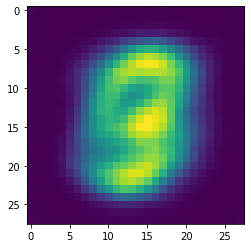

In [9]:
embedding = Model(input, l)
output = embedding.predict(x_train[0:2])
print(output.shape)

def generate_decoder(autoencoder, layers, encoding_size = 25):
    decoded_output = Input(shape=(encoding_size,))
    deco = autoencoder.layers[-1 * layers](decoded_output)
    for i in range(layers - 1, 0, -1):
        deco = autoencoder.layers[-1 * i](deco)
    decoding = Model(decoded_output, deco)
    decoding.summary()
    return(decoding)
decoder = generate_decoder(autoencoder, 8, 25)
reconstruction = decoder.predict(output)
print(x_train[0:2].shape)
print(output.shape)
print(reconstruction.shape)
#plt.imshow(x_train[0])

plt.imshow(decoder.predict(output)[0])



In [39]:
epochs = 50
batch_size = 32

input_layer = Input(shape=(25,))
x = Dense(30, activation="elu")(input_layer)
x = Dense(20, activation="elu")(x)
output_layer = Dense(10, activation='softmax')(x)
prediction_model = Model(input_layer, output_layer)
prediction_model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
prediction_model.summary()

x_train_embedding = embedding.predict(x_train)
x_test_embedding = embedding.predict(x_test)

prediction_model.fit(x_train_embedding, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (x_test_embedding, y_test))

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 25)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_41 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_42 (Dense)             (None, 10)                210       
Total params: 1,610
Trainable params: 1,610
Non-trainable params: 0
_________________________________________________________________


2021-11-26 18:38:46.064285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
  12/1875 [..............................] - ETA: 18s - loss: 2.3295 - accuracy: 0.0547

2021-11-26 18:38:50.538834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1872/1875 [============================>.] - ETA: 0s - loss: 0.7592 - accuracy: 0.7805

2021-11-26 18:39:07.568750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 19s 10ms/step - loss: 0.7587 - accuracy: 0.7807 - val_loss: 0.4005 - val_accuracy: 0.8817
Epoch 2/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3705 - accuracy: 0.8874 - val_loss: 0.3386 - val_accuracy: 0.9001
Epoch 3/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3354 - accuracy: 0.8979 - val_loss: 0.3194 - val_accuracy: 0.9051
Epoch 4/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3161 - accuracy: 0.9025 - val_loss: 0.3179 - val_accuracy: 0.9039
Epoch 5/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2996 - accuracy: 0.9078 - val_loss: 0.2845 - val_accuracy: 0.9135
Epoch 6/50
1875/1875 [==============================] - 20s 10ms/step - loss: 0.2847 - accuracy: 0.9115 - val_loss: 0.2604 - val_accuracy: 0.9195
Epoch 7/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2704 - accuracy: 0.9165 - val_loss: 0.2473 - val_accura

In [40]:
joint_model_layers = embedding.layers[-1].output
jml = prediction_model.layers[-3](joint_model_layers)
jml = prediction_model.layers[-2](jml)
jml = prediction_model.layers[-1](jml)

joint_model = Model(embedding.input, jml)

In [41]:
class custom_layer(Layer):
    def  __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(custom_layer,self).__init__(**kwargs)
    def build(self,input_shape):
        output_shape = self.compute_output_shape(input_shape)
        self.W=self.add_weight(name='kernel',
                           shape=(1,) + output_shape[1:],
                           constraint=tf.keras.constraints.NonNeg(),
                           initializer='uniform'                              ,
                           trainable=True)
        self.built = True
  # this self.built is necessary .
    def call(self,x):
        return x * self.W
    def compute_output_shape(self, input_shape):
        return(input_shape)

In [57]:
from tensorflow.keras.layers import Input, Dense, Layer, Lambda, Multiply, Reshape

sample_input = np.ones(10000 * 28 * 28).reshape(10000, 28, 28)
sample_output = np.array(10000 * [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])


joint_model.trainable = False

new_input_layer =  Input(shape=(28,28,1))
l = custom_layer((28,28,1))
# this is the layer whose weight we believe is going to be the minimum
new_weight_layer = l(new_input_layer)
transfer = joint_model(new_weight_layer, training=False)


optimization_model = Model(new_input_layer, transfer)
optimization_model.compile('sgd', loss = 'categorical_crossentropy')
optimization_model.summary()
# basic training framework that is used in keras
optimization_model.fit(sample_input, sample_output, batch_size=16, epochs=5, verbose = 1)
# the model that we trained previously


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
custom_layer_2 (custom_layer (None, 28, 28, 1)         784       
_________________________________________________________________
model_33 (Functional)        (None, 10)                86877     
Total params: 87,661
Trainable params: 784
Non-trainable params: 86,877
_________________________________________________________________
Epoch 1/5
  1/625 [..............................] - ETA: 3:00 - loss: 10.9941

2021-11-27 08:25:30.441063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 7s 11ms/step - loss: 0.0744
Epoch 2/5
625/625 [==============================] - 7s 11ms/step - loss: 0.0017
Epoch 3/5
625/625 [==============================] - 7s 11ms/step - loss: 0.0011
Epoch 4/5
625/625 [==============================] - 7s 11ms/step - loss: 8.1137e-04
Epoch 5/5
625/625 [==============================] - 7s 11ms/step - loss: 6.5505e-04


In [62]:
optimization_model.fit(sample_input, sample_output, batch_size=16, epochs=30, verbose = 1)

Epoch 1/30
625/625 [==============================] - 7s 11ms/step - loss: 1.1338e-04
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 1.1073e-04
Epoch 3/30
625/625 [==============================] - 7s 11ms/step - loss: 1.0823e-04
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - loss: 1.0584e-04
Epoch 5/30
625/625 [==============================] - 7s 11ms/step - loss: 1.0352e-04
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - loss: 1.0126e-04
Epoch 7/30
625/625 [==============================] - 7s 11ms/step - loss: 9.9158e-05
Epoch 8/30
625/625 [==============================] - 7s 11ms/step - loss: 9.7185e-05
Epoch 9/30
625/625 [==============================] - 7s 11ms/step - loss: 9.5278e-05
Epoch 10/30
625/625 [==============================] - 7s 11ms/step - loss: 9.3455e-05
Epoch 11/30
625/625 [==============================] - 7s 11ms/step - loss: 9.1699e-05
Epoch 12/30
625/625 [==============================]

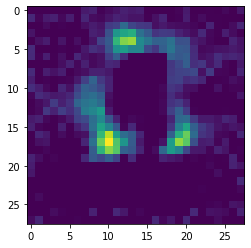

[[5.1610277e-06 1.9678517e-07 4.0928233e-02 7.2253577e-05 2.1368247e-02
  3.0442451e-03 9.2240971e-01 1.2154309e-02 3.4262089e-07 1.7279577e-05]]
[[1.3401997e-07 4.8629930e-14 6.0651240e-07 6.1211752e-10 1.6491877e-05
  4.8702739e-05 9.9993289e-01 1.2919630e-06 4.4041271e-11 3.0883163e-09]]


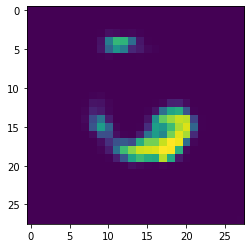

In [65]:
joint_model.predict(l.get_weights())

plt.imshow(l.get_weights()[0].reshape(28,28))
plt.show()
img = autoencoder.predict(l.get_weights())[0].reshape(28, 28)
plt.imshow(img)
print(joint_model.predict(img.reshape(1 ,28, 28, 1)))
print(joint_model.predict(l.get_weights()[0].reshape(1, 28,28, 1)))

In [60]:
img = np.array(l.get_weights())
img = img.reshape(1, 49)
new_output = decoding.predict(img)

prediction_model.predict(l.get_weights())


ValueError: cannot reshape array of size 784 into shape (1,49)

In [19]:
from tensorflow.keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dense


input_layer = Input(shape=(28,28,1))
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='sigmoid', input_shape = (28, 28, 1))(input_layer)
x = MaxPool2D(strides=(2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='sigmoid')(x)
x = MaxPool2D(strides=(2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
output_layer = Dense(10, activation='softmax')(x)
model = Model(input_layer, output_layer)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 16)          64  

In [19]:
from tensorflow.keras.layers import Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dense


input_layer = Input(shape=(28,28,1))
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='sigmoid', input_shape = (28, 28, 1))(input_layer)
x = MaxPool2D(strides=(2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='sigmoid')(x)
x = MaxPool2D(strides=(2,2))(x)
x = BatchNormalization()(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu')(x)
x = MaxPool2D(strides=(2,2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
output_layer = Dense(10, activation='softmax')(x)
model = Model(input_layer, output_layer)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 16)          64  

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [25]:
epochs = 10
batch_size = 512

model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (x_test, y_test))

Epoch 1/10
118/118 [==============================] - 3s 23ms/step - loss: 0.0561 - accuracy: 0.9830 - val_loss: 0.0726 - val_accuracy: 0.9781
Epoch 2/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0513 - accuracy: 0.9844 - val_loss: 0.0732 - val_accuracy: 0.9768
Epoch 3/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0478 - accuracy: 0.9855 - val_loss: 0.0716 - val_accuracy: 0.9800
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0444 - accuracy: 0.9868 - val_loss: 0.0676 - val_accuracy: 0.9798
Epoch 5/10
118/118 [==============================] - 3s 21ms/step - loss: 0.0408 - accuracy: 0.9876 - val_loss: 0.0720 - val_accuracy: 0.9773
Epoch 6/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0384 - accuracy: 0.9884 - val_loss: 0.0649 - val_accuracy: 0.9809
Epoch 7/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.0790 - val_accuracy: 0.9772

In [26]:
class custom_layer(Layer):
    def  __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(custom_layer,self).__init__(**kwargs)
    def build(self,input_shape):
        output_shape = self.compute_output_shape(input_shape)
        self.W=self.add_weight(name='kernel',
                           shape=(1,) + output_shape[1:],
                           constraint=tf.keras.constraints.NonNeg(),
                           initializer='uniform'                              ,
                           trainable=True)
        self.built = True
  # this self.built is necessary .
    def call(self,x):
        return x * self.W
    def compute_output_shape(self, input_shape):
        return(input_shape)


In [93]:
sample_input = np.ones(10000 * 28 * 28).reshape(10000, 28, 28)
sample_output = np.array(10000 * [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
sample_output.shape
print(x_train.shape)


(60000, 28, 28, 1)


In [28]:
from tensorflow.keras.layers import Input, Dense, Layer, Lambda, Multiply, Reshape
model.trainable = False
def my_loss_fn(y_true, y_pred):
    return  (1 - y_pred[0]) + tf.reduce_mean(y_pred, axis=-1) 

new_input_layer =  Input(shape=(28,28,1))
l = custom_layer((28,28,1))
# this is the layer whose weight we believe is going to be the minimum
new_weight_layer = l(new_input_layer)
transfer = model(new_weight_layer, training=False)


optimization_model = Model(new_input_layer, transfer)
optimization_model.compile('sgd', loss = 'categorical_crossentropy')
optimization_model.summary()
# basic training framework that is used in keras
optimization_model.fit(sample_input, sample_output, batch_size=1024, epochs=50, verbose = 1)
# the model that we trained previously
#transfer = model(new_weight_layer, training=False)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
custom_layer (custom_layer)  (None, 28, 28, 1)         784       
_________________________________________________________________
model_3 (Functional)         (None, 10)                5162      
Total params: 5,946
Trainable params: 784
Non-trainable params: 5,162
_________________________________________________________________
Epoch 1/50
 3/10 [========>.....................] - ETA: 0s - loss: 6.2393

2021-11-24 16:22:33.549852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 32ms/step - loss: 5.6989
Epoch 2/50
10/10 [==============================] - 0s 27ms/step - loss: 4.0493
Epoch 3/50
10/10 [==============================] - 0s 27ms/step - loss: 1.5508
Epoch 4/50
10/10 [==============================] - 0s 28ms/step - loss: 0.3342
Epoch 5/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0990
Epoch 6/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0564
Epoch 7/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0406
Epoch 8/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0320
Epoch 9/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0266
Epoch 10/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0230
Epoch 11/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0204
Epoch 12/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0182
Epoch 13/50
10/10 [=============================

In [ ]:
optimization_model.fit(sample_input, sample_output, batch_size=8, epochs=50, verbose = 1)



In [30]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = np.array(l.get_weights()).reshape(( 28, 28))


[[7.8372141e-06 1.7723161e-05 9.9993908e-01 2.4317018e-05 5.1481091e-09
  2.7174497e-06 4.0945881e-07 7.9448027e-06 7.3929620e-08 4.8044275e-09]]


2021-11-24 16:27:29.490902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


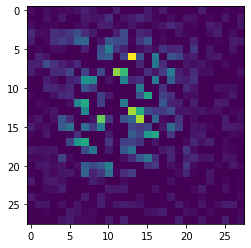

In [31]:
print(model.predict(img.reshape(1,28,28,1)))
img = img.reshape(28,28)
plt.imshow(img)

In [32]:
img.max()

0.5545107